# Predicting House Prices Using FastAI (DL), RandomForest, and XGBoost

First we set up the environment and load the data provided by Kaggle
(kaggle competitions download -c house-prices-advanced-regression-techniques)

In [82]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/houseprice/'

In [83]:
import pandas as pd
import numpy as np

train_file_path = ('data/houseprice/train.csv')
test_file_path = ('data/houseprice/test.csv')
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

Data exploration: what's in the training dataset? 
We see 81 columns including the house index and our target (sale price).
There is a mix of numerical and categorical variables.
The training set contains missing values. 

In [84]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In the test set, we have all predictor variables, including the Id. We will drop the Id later as it shouldn't affect our predition. 

Note that the test set also contains NaNs, and they're sprinkled in different columns than in the training set.

In [85]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [86]:
#print('NaNs in train:\n',train_data.isnull().sum(),'\n'
#      'NaNs in test:\n',test_data.isnull().sum())

For simplicity, I won't be creating any additional features. So let's split up numerical and categorical variables.The splitting is based off the data description. Although some variables may not look important in the decision-making process, we'll keep them for now in case it proves to be relevant.

In [87]:
num_vars = ['LotFrontage','LotArea','BsmtUnfSF','TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea','BsmtFinSF1','BsmtFinSF2','2ndFlrSF','MasVnrArea',
           'WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch']
cat_vars = ['MSSubClass', 'MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope',
            'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt',
            'YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
            'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir', 
            'Electrical','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr','KitchenQual', 
            'TotRmsAbvGrd','Functional','Fireplaces','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond',
            'PavedDrive','PoolQC','Fence','MiscFeature','MoSold','YrSold','SaleType','SaleCondition','3SsnPorch','PoolArea','MiscVal','LowQualFinSF']

Since we'll be using seaborn distplot to examine the data distribution, we'll fill the missing values now.
The missing values in numerical varaiables are likely missing because the feature doesn't exist (as opposed to exist but not entered). We could create new binary variables to keep track of whether a feature exists, but for simplicity, I'll just fill NaNs in numercial variables with 0 to represent the lack of feature. I'll also fill categorical NaNs with empty string to denote a new level, which will later be one-hot encodded.  

In [88]:
for col in num_vars: 
    train_data[col] = train_data[col].replace(np.nan, 0, regex=True)
    test_data[col] = test_data[col].replace(np.nan, 0, regex=True)
for col in cat_vars:
    train_data[col] = train_data[col].replace(np.nan, 'Unknown', regex=True)
    test_data[col]= test_data[col].replace(np.nan, 'Unknown', regex=True)

In [89]:
dep = 'SalePrice'
target = train_data[dep]
house_id = 'Id'

num_var_train = train_data[num_vars+[dep]]
cat_var_train = train_data[cat_vars]

num_var_test = test_data[num_vars]
cat_var_test = test_data[cat_vars]

Let's see how the training data is distributed and try to answer the following questions with some visuals: 
1. What's the range of numerical variables? Can some of these numerical variables be seen as categoricals instead? (use of embeddings later for categoricals could be beneficial as it adds more weights for training)
2. What's the distribution of numerical variables?
3. What's the distribution of categorical variables?
4. How do they relate to sale price?

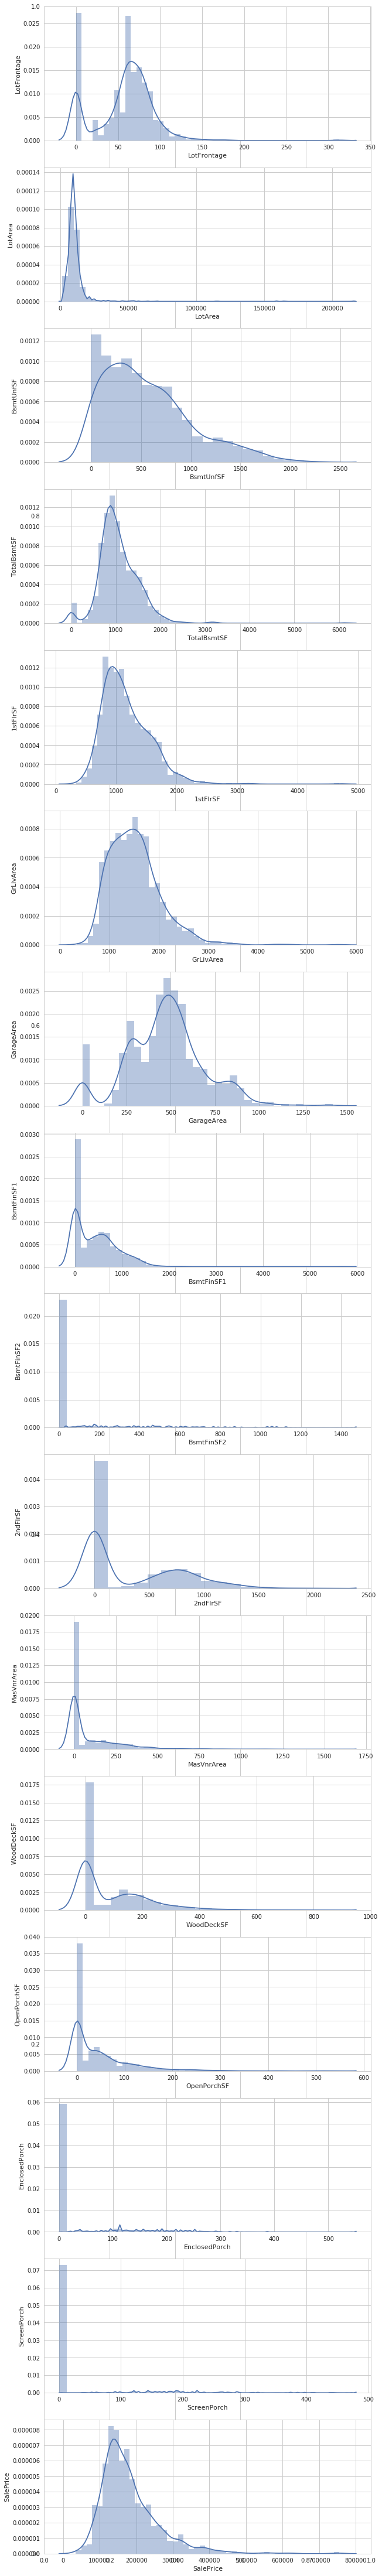

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_row = len(num_var_train.columns)
plot_column = 1
i=1
fig, ax = plt.subplots(figsize=(10, 80))
while i< plot_row:
    for var in num_var_train.columns: 
        fig.add_subplot(plot_row, plot_column,i)
        sns.distplot(num_var_train[var])
        plt.ylabel(var)
        plt.xlabel(var)        
        i +=1
plt.show()

In [42]:
sns.set(style="whitegrid", color_codes=True)

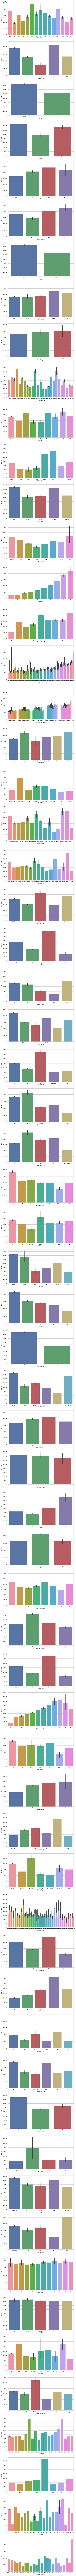

In [43]:
sns.set_context()
plot_row = len(cat_var_train.columns)
plot_column = 1
i=1
fig, ax = plt.subplots()
fig.set_size_inches(10,400)
while i< plot_row:
    for var in cat_var_train.columns: 
        fig.add_subplot(plot_row, plot_column,i)
        sns.barplot(x = var, y="SalePrice", data=train_data)
        plt.ylabel("SalePrice")
        plt.xlabel(var)        
        i +=1
plt.show()

We see a couple of problems with numericals: 
1. The numerical scale is quite different among some variables.
2. Most variables aren't normally distributed, which may make training and searching of global minimum more difficult. 
3. Because we encoded numerical NaN's as zeros, and there are quite a lot of them - they now are outliers in the variable distribution. 

Some ideas for solutions: 
1. We could rescale the variables (linear scaling, such as MinMax). I'm not gonna do it here since the linear scaling can be countered by adjusting weights and biases during training anyway.
2. I do want to normalize my input so that they look more normal-distribution-like; the idea is to make sure that all my inputs are within the NN function domain so that the SDG can accurately find minima.
3. We could drop the NaNs at the beginning, and our data would look a lot more normal-like. But since a lack of certain feature may play into decision-making, I decided to sacrifice normality and keep these zeros. 

Note on using the fast ai library: 
In its structured.py module, the data processing (df_proc) step uses scikit's StandardScaler. But looking at our data, with skewness and outliers, StandardScaler may not work very well. 

There are several other options in sklearn that we could try: 
1. RobustScaler: linear scaler that uses the median and 25%-75% quantile range instead of mean and stdev
2. QuantileTransformer: non-linear scaler that ranks data by their quantile, match them to a reference distribution (uniform or normal), and uses the quantile average to represent the transformed data. The transformed data preserves the original data ranking.

Normalization of weights and biases will be done through PyTorch's nn.BatchNorm during model fitting. 

In [91]:
from sklearn.preprocessing import RobustScaler,StandardScaler,Normalizer,QuantileTransformer,MinMaxScaler

def scale_vars_quantile(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n], QuantileTransformer(output_distribution='normal')) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [92]:
def proc_df_quantile(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=True, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    ignore_flds: A list of fields that are ignored during processing.

    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    #for numerical: original code takes mean and create new columns;
    #here I already replaced nan's with 0, since subbing in average for a non-existant feature doesn't make sense
    #for cat: create new level 
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars_quantile(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    #encode different categorical values
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [93]:
joined = train_data[[house_id]+cat_vars+num_vars+[dep]]

In [94]:
test_data[dep] = 0
joined_test = test_data[[house_id]+cat_vars+num_vars+[dep]]

Cast type 'category' on all categorical variables in the training set

In [95]:
for v in cat_vars: joined.loc[:,v] = joined.loc[:,v].astype('category').cat.as_ordered()

Apply the same category and levels to the test set 

In [96]:
apply_cats(joined_test, joined)

Similarly, we'll cast type float32 on all of our numerical variables to help data processing later.

In [97]:
for v in num_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

We'll be using the entire dataset

In [98]:
n = len(joined)
samp_size = n
joined_samp = joined

In [100]:
#process data
df, y, nas, mapper = proc_df_quantile(joined_samp, 'SalePrice',skip_flds=['Id'], do_scale=True)
#expressing target as log for metrics later
y_log = np.log(y)
max_y_log = np.max(y_log)
y_range = (0, max_y_log*1.2)

In [101]:
df_test, _, nas, mapper = proc_df_quantile(joined_test, 'SalePrice', skip_flds=['Id'],do_scale=True,
                                 mapper=mapper, na_dict=nas)

In [102]:
#pick the last 25% of rows as validation set (doesn't need to be sorted)
train_ratio = 0.8
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(joined_samp)))

In [103]:
df.describe()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GrLivArea,GarageArea,BsmtFinSF1,BsmtFinSF2,2ndFlrSF,MasVnrArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,5.166438,4.028767,1.995890,2.903425,2.942466,3.777397,1.000685,4.019178,1.062329,13.251370,...,0.000139,-0.174599,-1.303571,-4.409491,-2.557141,-2.705190,-2.309670,-1.938461,-4.231619,-4.636621
std,4.161951,0.632017,0.063996,0.394776,1.409156,0.707666,0.026171,1.622634,0.276232,6.013735,...,1.013030,1.500280,2.734727,2.204671,3.054385,3.047932,3.045592,2.984708,2.382235,1.920949
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337
25%,1.000000,4.000000,2.000000,3.000000,1.000000,4.000000,1.000000,3.000000,1.000000,8.000000,...,-0.675014,-0.666175,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337
50%,5.000000,4.000000,2.000000,3.000000,4.000000,4.000000,1.000000,5.000000,1.000000,13.000000,...,0.000538,0.018820,0.001023,-5.199337,-5.199337,-5.199337,-5.199337,0.005018,-5.199337,-5.199337
75%,7.000000,4.000000,2.000000,3.000000,4.000000,4.000000,1.000000,5.000000,1.000000,18.000000,...,0.673310,0.651824,0.674288,-5.199337,0.668987,0.674288,0.664287,0.673702,-5.199337,-5.199337
max,15.000000,5.000000,2.000000,3.000000,4.000000,4.000000,2.000000,5.000000,3.000000,25.000000,...,5.199337,5.199337,5.199337,5.199337,5.199337,5.199337,5.199337,5.199337,5.199337,5.199337


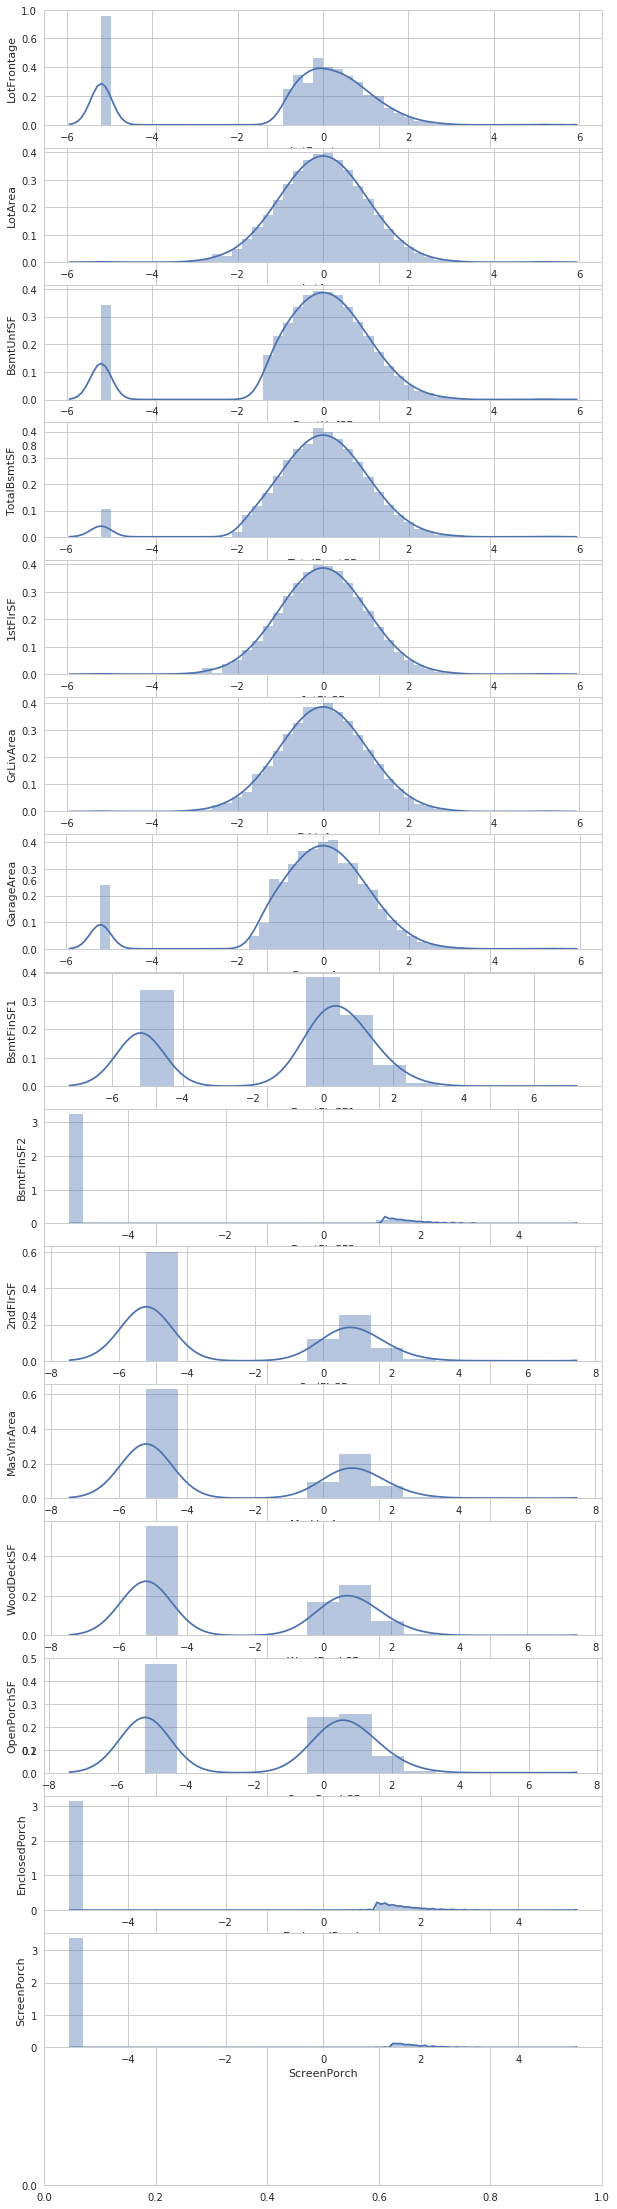

In [104]:
#plot transformed train num vars
import matplotlib.pyplot as plt
import seaborn as sns

plot_row = len(num_var_train.columns)
plot_column = 1
i=1
fig, ax = plt.subplots(figsize=(10, 40))
while i< plot_row:
    for var in df[num_vars].columns: 
        fig.add_subplot(plot_row, plot_column,i)
        sns.distplot(df[var])
        plt.ylabel(var)
        plt.xlabel(var)        
        i +=1
plt.show()

# The metrics

In [105]:
from sklearn.metrics import mean_squared_log_error
def inv_y(a): return np.exp(a)

def rmsle(y_predicted, y_actual):
    y_predicted = inv_y(y_predicted)
    y_actual = inv_y(y_actual)
    rmsle = np.sqrt(mean_squared_log_error(y_actual, y_predicted))
    return rmsle

# DL 

In [106]:
md = ColumnarModelData.from_data_frame(PATH, val_idx,df, y_log.astype(np.float32), cat_flds=cat_vars, bs=5, test_df = df_test)

In [107]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [108]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [109]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [110]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 65%|██████▌   | 153/234 [00:02<00:01, 54.98it/s, loss=5.85]


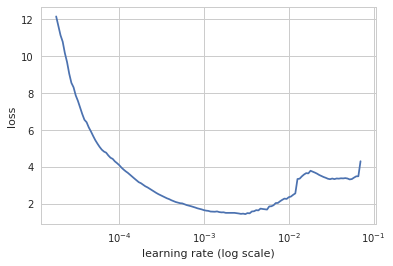

In [111]:
m.sched.plot(10)

In [112]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [113]:
m.fit(lr, 1, metrics=[rmsle])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                       
    0      0.27473    0.131933   0.354927  



[0.13193310176332793, 0.3549267664551735]

In [114]:
m.fit(lr, 3, metrics=[rmsle], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                        
    0      0.0842     0.068382   0.227804  
    1      0.056795   0.052516   0.212705                     
    2      0.034824   0.037418   0.178501                     



[0.037418386153876784, 0.17850089247028034]

In [115]:
m.fit(lr, 3, metrics=[rmsle], cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                        
    0      0.051296   0.041822   0.187703  
    1      0.02642    0.029837   0.159324                     
    2      0.043617   0.040005   0.190899                     
    3      0.02197    0.027909   0.149397                     
    4      0.029934   0.03145    0.166886                     
    5      0.017514   0.026051   0.146278                     



[0.026050833030603827, 0.14627782044311363]

# Test Time

In [116]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3
lr = 1e-3

In [117]:
m.fit(lr, 3, metrics=[rmsle], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                      
    0      17.840985  17.896039  4.228062  
    1      17.90662   17.896039  4.228062                   
    2      17.965621  17.896039  4.228062                   



[17.896038913726805, 4.228062423070272]

In [118]:
m.fit(lr, 3, metrics=[rmsle], cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   rmsle                       
    0      0.463447   0.07678    0.255078  
    1      0.053917   0.052237   0.204613                     
    2      0.050125   0.042827   0.191394                     
    3      0.024819   0.038771   0.179611                     
    4      0.041406   0.040234   0.190669                     
    5      0.019506   0.032539   0.166922                     



[0.03253892796734969, 0.16692218308647475]

Now training_loss is getting lower than validation_loss. We should probably stop now to avoid overfitting. Let's predict something!

In [119]:
x, y = m.predict_with_targs()

In [120]:
rmsle(x, y)

0.18135896

In [121]:
pred_test = m.predict(is_test=True)

In [122]:
pred_test = np.exp(pred_test)

In [123]:
joined_test['SalePrice']=pred_test

In [126]:
csv_HousePrice = f'{PATH}tmp/sub.csv'

In [127]:
joined_test[['Id','SalePrice']].to_csv(csv_HousePrice, index=False)

In [128]:
FileLink(csv_HousePrice)

/home/paperspace/fastai/courses/dl1/data/houseprice/tmp/sub.csv

# Comparison to Random Forest

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y_log)

In [131]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [132]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, rmsle(preds, y_val)

(0.9729133301328422,
 0.8595727370065788,
 0.8638178967663739,
 0.14655955976387797)

# XGBoost

In [135]:
from xgboost import XGBRegressor

boost_model = XGBRegressor()
boost_model.fit(trn, y_trn)
boost_pred = boost_model.predict(val)
error = rmsle(boost_pred, y_val)

error

0.13521270308327635

Curiously, DL doesn't seem to have worked very well. This could be either the nature of the dataset, or because of my implementaiton of the DL framework. I'll look into this a bit more in the future.